<a href="https://colab.research.google.com/github/haminhtien99/re3-pytorch/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch
# !git clone https://github.com/danielgordon10/re3-pytorch

/content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch


### Tracking


In [3]:
%cd /content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch
import os.path
import sys
import time

import cv2
import numpy as np


from re3_utils.util import bb_util
from re3_utils.util import im_util
from re3_utils.pytorch_util import pytorch_util_functions as pt_util

from tracker.network import Re3Net, Re3SmallNet

# Network Constants
from constants import CROP_SIZE
from constants import CROP_PAD
from constants import LOG_DIR
from constants import MAX_TRACK_LENGTH
from constants import USE_SMALL_NET

SPEED_OUTPUT = True


class Re3Tracker(object):
    def __init__(self, gpu_id=0):
        gpu_id = pt_util.setup_devices(gpu_id)[0]
        self.network = Re3SmallNet(gpu_id)
        pt_util.restore_from_folder(self.network, os.path.join(LOG_DIR, "checkpoints"))
        # if USE_SMALL_NET:
        #     self.network = Re3SmallNet(gpu_id)
        #     pt_util.restore_from_folder(self.network, os.path.join(LOG_DIR, "checkpoints_small"))
        # else:
        #     self.network = Re3Net(gpu_id)
        #     pt_util.restore_from_folder(self.network, os.path.join(LOG_DIR, "checkpoints"))
        self.network.to(gpu_id)
        self.network.eval()


        self.tracked_data = {}

        self.t_time = 0
        self.total_forward_count = -1

    # unique_id{str}: A unique id for the object being tracked.
    # image{str or numpy array}: The current image or the path to the current image.
    # starting_box{None or 4x1 numpy array or list}: 4x1 bounding box in X1, Y1, X2, Y2 format.
    def track(self, unique_id, image, starting_box=None):
        start_time = time.time()

        if type(image) == str:
            image = cv2.imread(image)[:, :, ::-1]
        else:
            image = image.copy()

        image_read_time = time.time() - start_time

        if starting_box is not None:
            lstm_state = None
            past_bbox = np.array(starting_box)  # turns list into numpy array if not and copies for safety.
            prev_image = image
            original_features = None
            forward_count = 0
        elif unique_id in self.tracked_data:
            lstm_state, past_bbox, prev_image, original_features, forward_count = self.tracked_data[unique_id]
        else:
            raise Exception("Unique_id %s with no initial bounding box" % unique_id)

        cropped_input0, past_b_box_padded = im_util.get_cropped_input(prev_image, past_bbox, CROP_PAD, CROP_SIZE)
        cropped_input1, _ = im_util.get_cropped_input(image, past_bbox, CROP_PAD, CROP_SIZE)
        # import pdb
        # pdb.set_trace()

        image_input = pt_util.from_numpy((np.stack([cropped_input0, cropped_input1])))
        raw_output = self.network(image_input, lstm_state)
        raw_output = pt_util.to_numpy_array(raw_output)
        lstm_state = self.network.lstm_state
        if forward_count == 0:
            original_features = [var.clone().detach() for var in self.network.lstm_state]

        prev_image = image

        # Shift output box to full image coordinate system.
        output_box = bb_util.from_crop_coordinate_system(raw_output.squeeze() / 10.0, past_b_box_padded, 1, 1)
        # import pdb
        # pdb.set_trace()
        if forward_count > 0 and forward_count % MAX_TRACK_LENGTH == 0:
            cropped_input, _ = im_util.get_cropped_input(image, output_box, CROP_PAD, CROP_SIZE)
            image_input = pt_util.from_numpy(np.tile(cropped_input[np.newaxis, ...], (2, 1, 1, 1)))
            self.network(image_input, original_features)
            lstm_state = self.network.lstm_state

        forward_count += 1
        self.total_forward_count += 1

        if starting_box is not None:
            # Use label if it's given
            output_box = np.array(starting_box)

        self.tracked_data[unique_id] = (lstm_state, output_box, image, original_features, forward_count)
        end_time = time.time()
        if self.total_forward_count > 0:
            self.t_time += end_time - start_time - image_read_time
        if SPEED_OUTPUT and self.total_forward_count % 100 == 0:
            print("Current tracking speed:   %.3f FPS" % (1 / (end_time - start_time - image_read_time)))
            print("Current image read speed: %.3f FPS" % (1 / (image_read_time)))
            print("Mean tracking speed:      %.3f FPS\n" % (self.total_forward_count / max(0.00001, self.t_time)))
        return output_box


/content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch


In [4]:
%cd /content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch
import glob
import os.path
import sys

import cv2

# basedir = os.path.dirname(__file__)
# sys.path.append(os.path.abspath(os.path.join(basedir, os.path.pardir)))
from tracker import re3_tracker
tracker = Re3Tracker()



/content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch
restoring from /content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch/logs/checkpoints
restoring from /content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch/logs/checkpoints/iteration_0017030.pt
Restoring:
feature_extractor.0.conv.weight -> 	torch.Size([32, 3, 7, 7]) = 0MB
feature_extractor.0.conv.bias -> 	torch.Size([32]) = 0MB
feature_extractor.0.bn.weight -> 	torch.Size([32]) = 0MB
feature_extractor.0.bn.bias -> 	torch.Size([32]) = 0MB
feature_extractor.1.conv.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
feature_extractor.1.conv.bias -> 	torch.Size([64]) = 0MB
feature_extractor.1.bn.weight -> 	torch.Size([64]) = 0MB
feature_extractor.1.bn.bias -> 	torch.Size([64]) = 0MB
feature_extractor.3.conv.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
feature_extractor.3.conv.bias -> 	torch.Size([128]) = 0MB
feature_extractor.3.bn.weight -> 	torch.Size([128]) = 0MB
feature_extractor.3.bn.bias -> 	torch.Size([128]) = 0MB
feature_extractor.5.co

In [8]:
from google.colab.patches import cv2_imshow


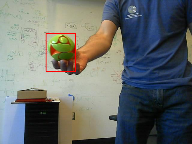

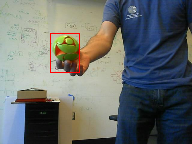

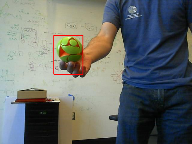

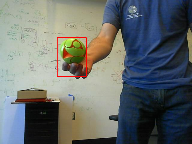

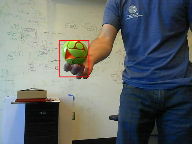

Current tracking speed:   203.884 FPS
Current image read speed: 148.539 FPS
Mean tracking speed:      133.394 FPS



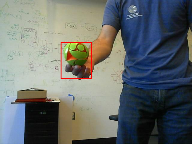

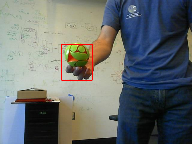

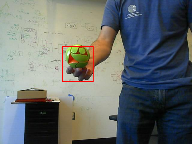

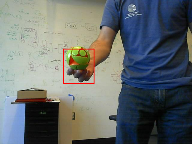

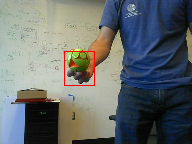

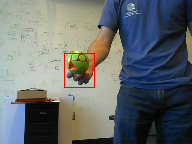

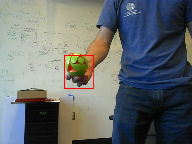

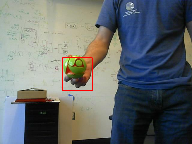

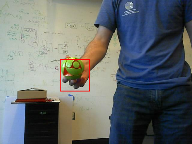

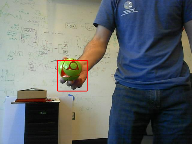

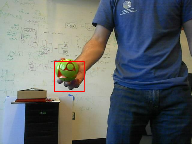

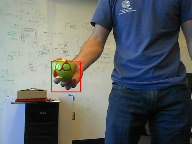

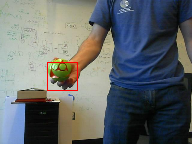

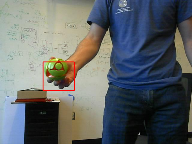

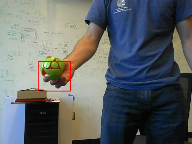

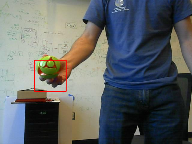

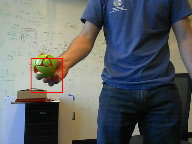

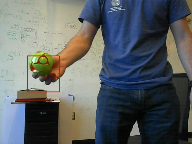

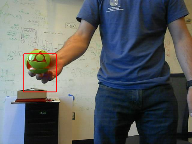

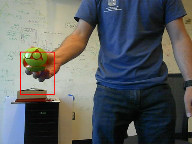

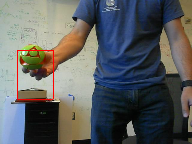

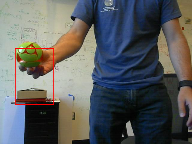

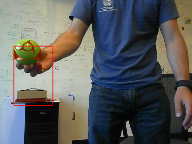

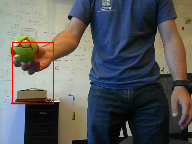

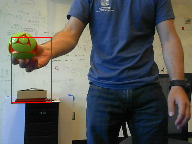

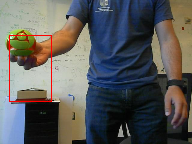

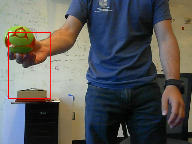

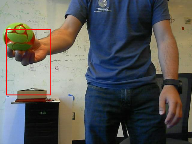

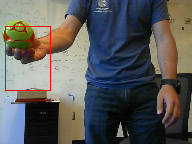

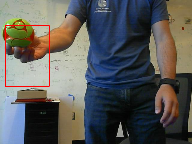

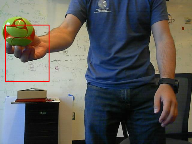

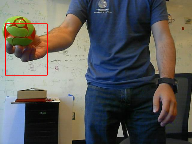

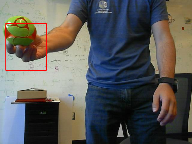

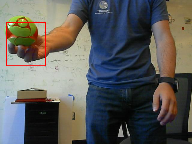

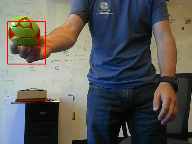

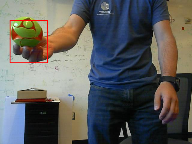

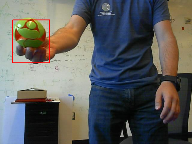

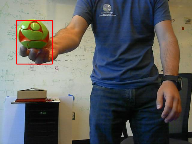

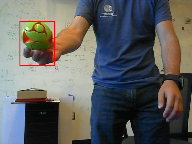

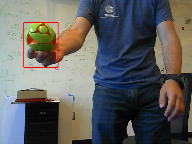

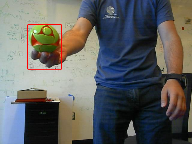

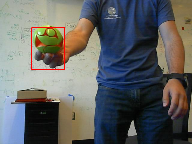

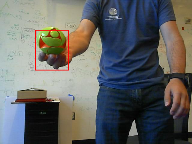

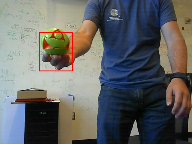

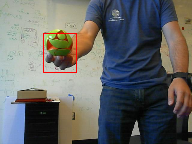

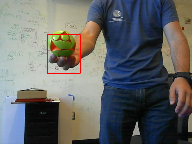

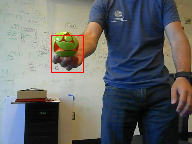

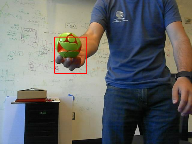

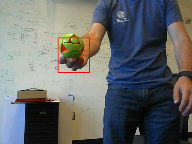

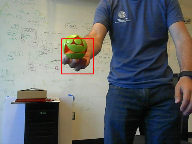

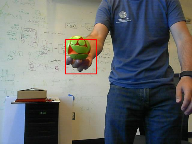

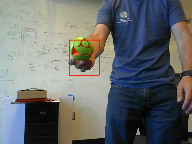

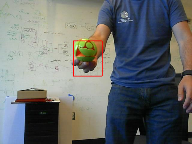

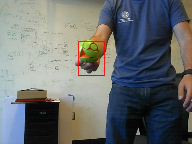

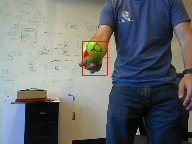

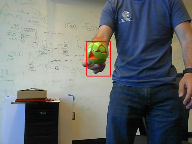

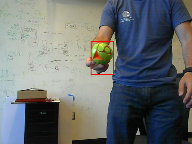

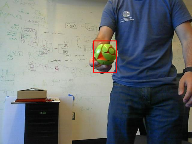

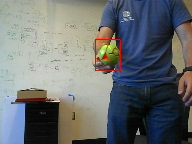

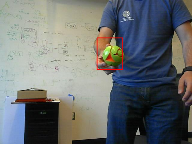

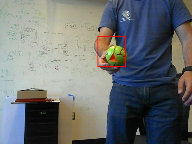

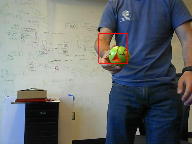

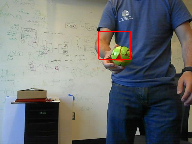

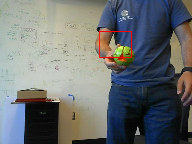

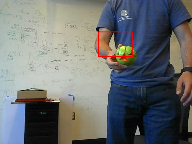

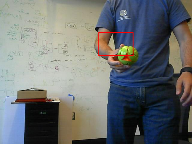

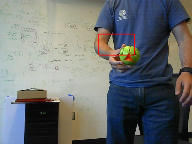

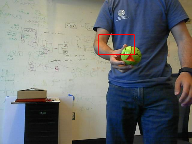

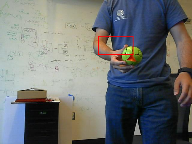

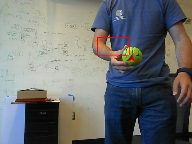

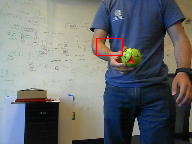

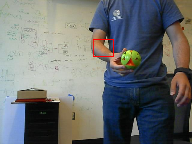

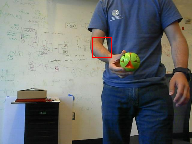

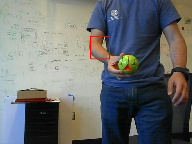

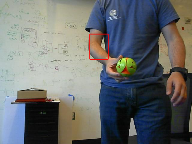

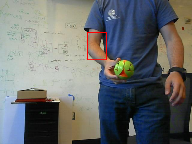

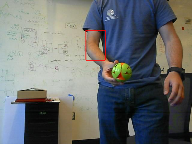

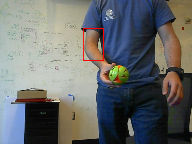

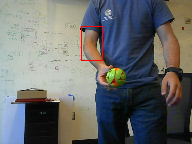

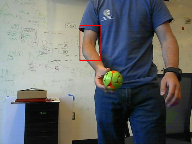

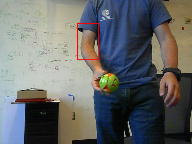

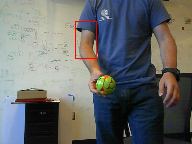

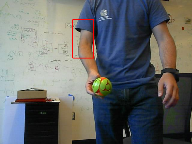

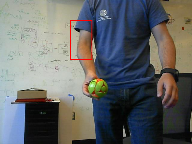

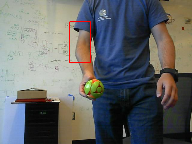

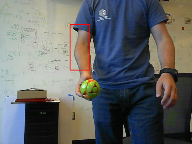

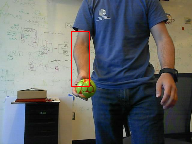

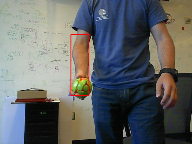

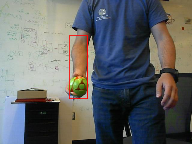

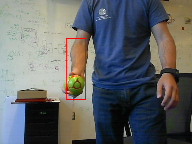

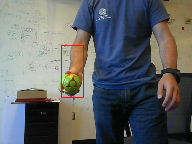

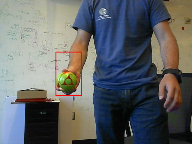

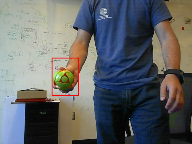

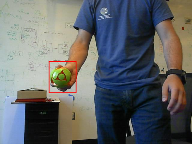

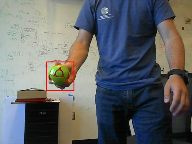

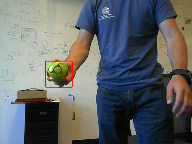

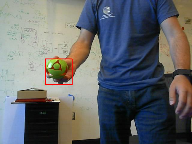

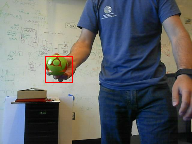

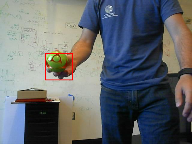

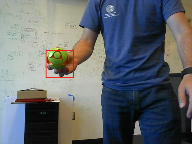

Current tracking speed:   125.932 FPS
Current image read speed: 208.299 FPS
Mean tracking speed:      138.478 FPS



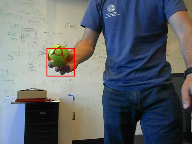

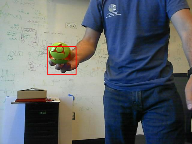

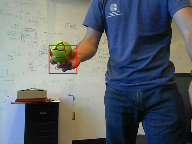

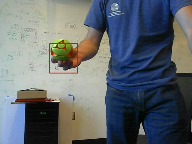

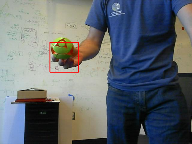

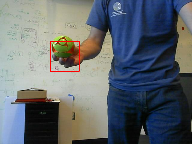

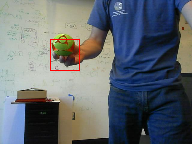

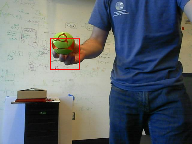

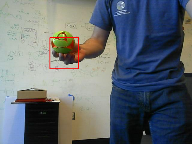

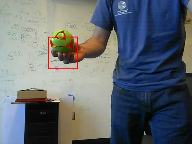

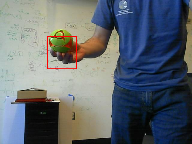

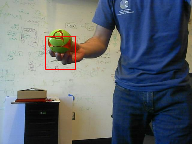

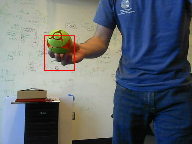

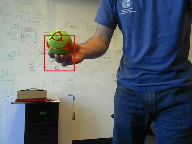

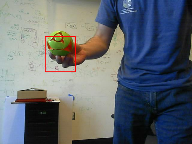

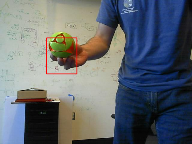

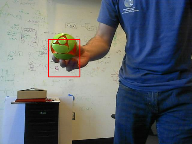

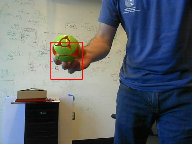

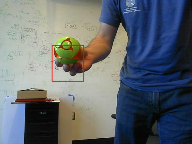

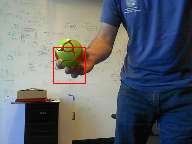

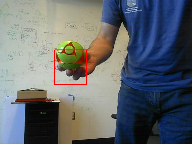

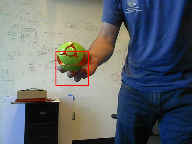

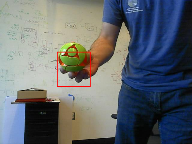

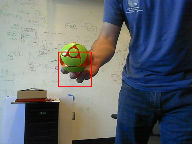

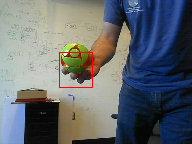

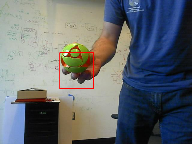

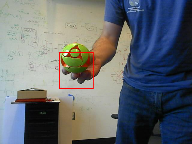

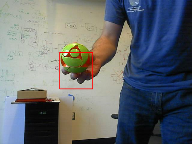

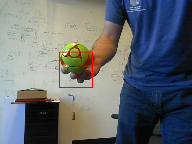

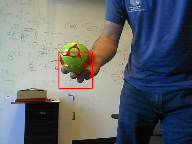

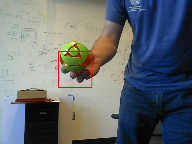

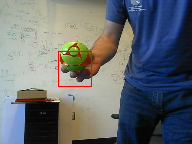

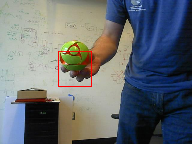

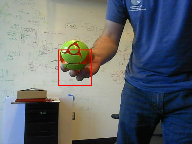

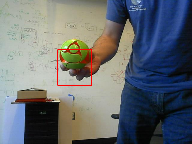

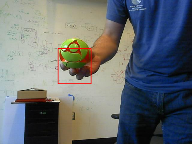

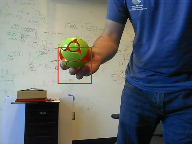

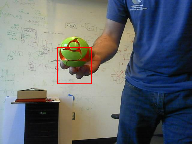

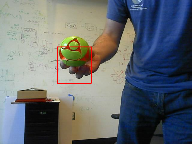

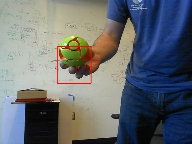

In [11]:

test_folder = "/content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch/data/sample_dataset/test/images/"
track_folder = "/content/drive/MyDrive/Re3-Object-Tracking/re3-pytorch/logs/tracked/"
test_files = [f for f in os.listdir(test_folder) if f.endswith(".jpg")]
test_files.sort()
initial_bbox = [154, 112, 254, 238]
image = cv2.imread( test_folder + test_files[0])

tracker.track("ball", test_folder + test_files[0], initial_bbox)
for file in test_files:
    image_path = test_folder + file
    # print(image_path)
    image = cv2.imread(image_path)
    # Tracker expects RGB, but opencv loads BGR.
    imageRGB = image[:, :, ::-1]
    bbox = tracker.track("ball", imageRGB)
    # print(bbox)
    width, height = image.shape[1], image.shape[0]
    image = cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), [0, 0, 255], 2)
    imageResize = cv2.resize(image, (int(width*0.3), int(height*0.3)))
    cv2_imshow(imageResize)
    cv2.waitKey(1) & 0xff
cv2.destroyAllWindows()